<a href="https://colab.research.google.com/github/ArashDehghanyan/ml-practicres/blob/main/Segmrentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
! pip install git+https://github.com/tensorflow/examples.git

  Cloning https://github.com/tensorflow/examples.git to /tmp/pip-req-build-t0z30py2
  Running command git clone -q https://github.com/tensorflow/examples.git /tmp/pip-req-build-t0z30py2
  Created wheel for tensorflow-examples: filename=tensorflow_examples-a7064dbb7c144eaac791dbc910e82230f5aeff9d_-py3-none-any.whl size=269030 sha256=8f3d4ca0d1cfba2c65ae97c863fa7a6739e5c814eca35c3548be64ab8b173700
  Stored in directory: /tmp/pip-ephem-wheel-cache-2yk8znk3/wheels/eb/19/50/2a4363c831fa12b400af86325a6f26ade5d2cdc5b406d552ca
Failed to build tensorflow-examples
    Running setup.py install for tensorflow-examples ... done
  DEPRECATION: tensorflow-examples was installed using the legacy 'setup.py install' method, because a wheel could not be built for it. A possible replacement is to fix the wheel build issue reported above. You can find discussion regarding this at https://github.com/pypa/pip/issues/8368.


In [2]:
import tensorflow as tf

import tensorflow_datasets as tfds

In [3]:
from tensorflow_examples.models.pix2pix import pix2pix

from IPython.display import clear_output
from matplotlib import pyplot as plt

#Download Oxford IIIT Pet dataset

In [4]:
dataset, info = tfds.load('oxford_iiit_pet:3.*.*', with_info=True)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/oxford_iiit_pet/3.2.0.incompleteJ3ZZWP/oxford_iiit_pet-train.tfrecord


  0%|          | 0/3680 [00:00<?, ? examples/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/oxford_iiit_pet/3.2.0.incompleteJ3ZZWP/oxford_iiit_pet-test.tfrecord


  0%|          | 0/3669 [00:00<?, ? examples/s]

Dataset oxford_iiit_pet downloaded and prepared to /root/tensorflow_datasets/oxford_iiit_pet/3.2.0. Subsequent calls will reuse this data.


In [5]:
def normalize(input_image, input_mask):
    input_image = tf.cast(input_image, tf.float32) / 255.
    input_mask -= 1
    return input_image, input_mask

def load_image(datapoint):
    """Resize and Normalize the input images and masks."""
    input_image = tf.image.resize(datapoint['image'], (128, 128))
    input_mask = tf.image.resize(datapoint['segmentation_mask'], (128, 128))

    input_image, input_mask = normalize(input_image, input_mask)
    return input_image, input_mask

In [6]:
TRAIN_LENGTH = info.splits['train'].num_examples
BATCH_SIZE = 64
BUFFER_SIZE = 1000
STEPS_PER_EPOCH = TRAIN_LENGTH // BATCH_SIZE

In [7]:
AUTOTUNE = tf.data.AUTOTUNE

train_images = dataset['train'].map(load_image, num_parallel_calls=AUTOTUNE)
test_images = dataset['test'].map(load_image, num_parallel_calls=AUTOTUNE)

###Simple Augmentation

In [8]:
class Augment(tf.keras.layers.Layer):
    def __init__(self, seed=42):
        super().__init__()
        # Use the same seed, so they will make the same random changes
        self.augment_inputs = tf.keras.layers.RandomFlip('horizontal', seed=seed)
        self.augment_labels = tf.keras.layers.RandomFlip('horizontal', seed=seed)

    def call(self, inputs, labels):
        inputs = self.augment_inputs(inputs)
        labels = self.augment_labels(labels)
        return inputs, labels

###Build input pipeline

In [9]:
train_batches = (
    train_images.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat().map(Augment()).prefetch(buffer_size=AUTOTUNE)
)

test_batches = test_images.batch(BATCH_SIZE)

###Visualization

In [10]:
def display(display_list):
    plt.figure(figsize=(15, 15))

    title = ['Input image', 'True mask', 'Predicted mask']
    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i+1)
        plt.imshow(tf.keras.utils.array_to_img(display_list[i]))
        plt.title(title[i])
        plt.axis('off')
    plt.show()


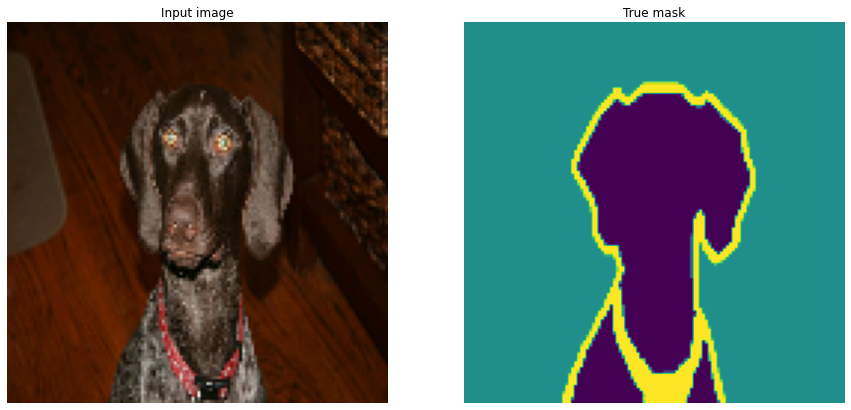

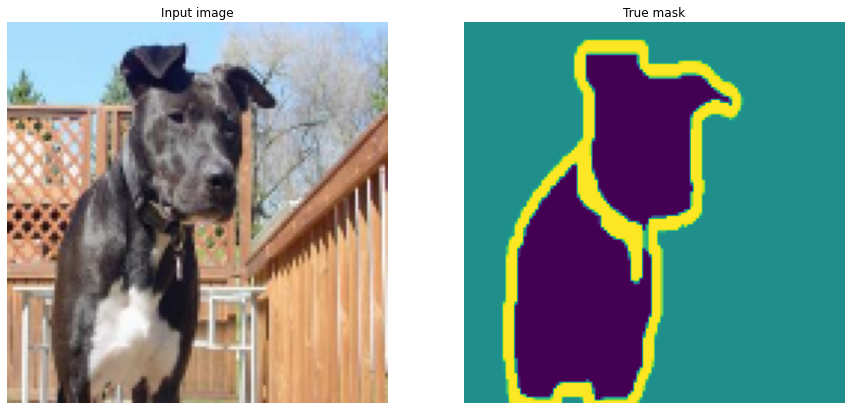

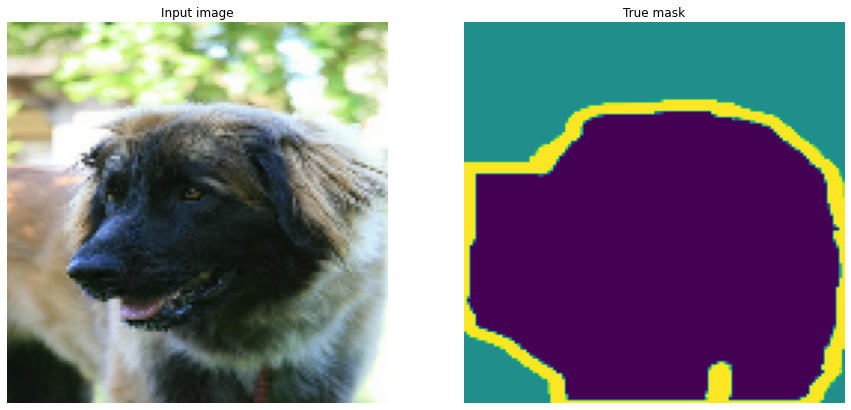

In [11]:
for images, masks in train_batches.take(3):
    sample_image, sample_mask = images[0], masks[0]
    display([sample_image, sample_mask])

##Define U-Net model

In [12]:
base_model = tf.keras.applications.MobileNetV2(input_shape=[128, 128, 3], include_top=False)

# USe the activations of these layers
layer_names = [
    'block_1_expand_relu',  # 64x64
    'block_3_expand_relu',  # 32x32
    'block_6_expand_relu',  # 16x16
    'block_13_expand_relu', # 8x8
    'block_16_project',     # 4x4
]

base_model_outputs = [base_model.get_layer(name).output for name in layer_names]

# Create the encoder (feature extraction) model
down_stack = tf.keras.models.Model(inputs=base_model.input, outputs=base_model_outputs)
down_stack.trainable = False

9420800/9406464 [==============================] - 0s 0us/step


In [13]:
# Decoder or upsamplar model
up_stack = [
    pix2pix.upsample(512, 3),
    pix2pix.upsample(256, 3),
    pix2pix.upsample(128, 3),
    pix2pix.upsample(64, 3),
]

In [14]:
skips = down_stack(tf.expand_dims(sample_image, 0))
print(skips[-1].shape)
x = skips[-1]
skips = reversed(skips[:-1])
for s in skips:
    print(s.shape)
x = up_stack[0](x)

print(x.shape)

(1, 4, 4, 320)
(1, 8, 8, 576)
(1, 16, 16, 192)
(1, 32, 32, 144)
(1, 64, 64, 96)
(1, 8, 8, 512)


In [15]:
# Define U-Net model
def unet_model(output_channels:int):
    inputs = tf.keras.layers.Input(shape=[128, 128, 3])
    
    # Down sampling through the model
    skips = down_stack(inputs)
    x = skips[-1]
    skips = reversed(skips[:-1])

    # Up sampling and establishing the skip connections
    for up, skip in zip(up_stack, skips):
        x = up(x)
        concat = tf.keras.layers.Concatenate()
        x = concat([x, skip])

    # This is the last layer of the model
    last = tf.keras.layers.Conv2DTranspose(filters=output_channels, 
                                           kernel_size=3, strides=(2, 2), 
                                           padding='same')
    x = last(x)
    return tf.keras.Model(inputs=inputs, outputs=x)
    

In [16]:
OUTPUT_CLASSES = 3

model = unet_model(output_channels=OUTPUT_CLASSES)
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)


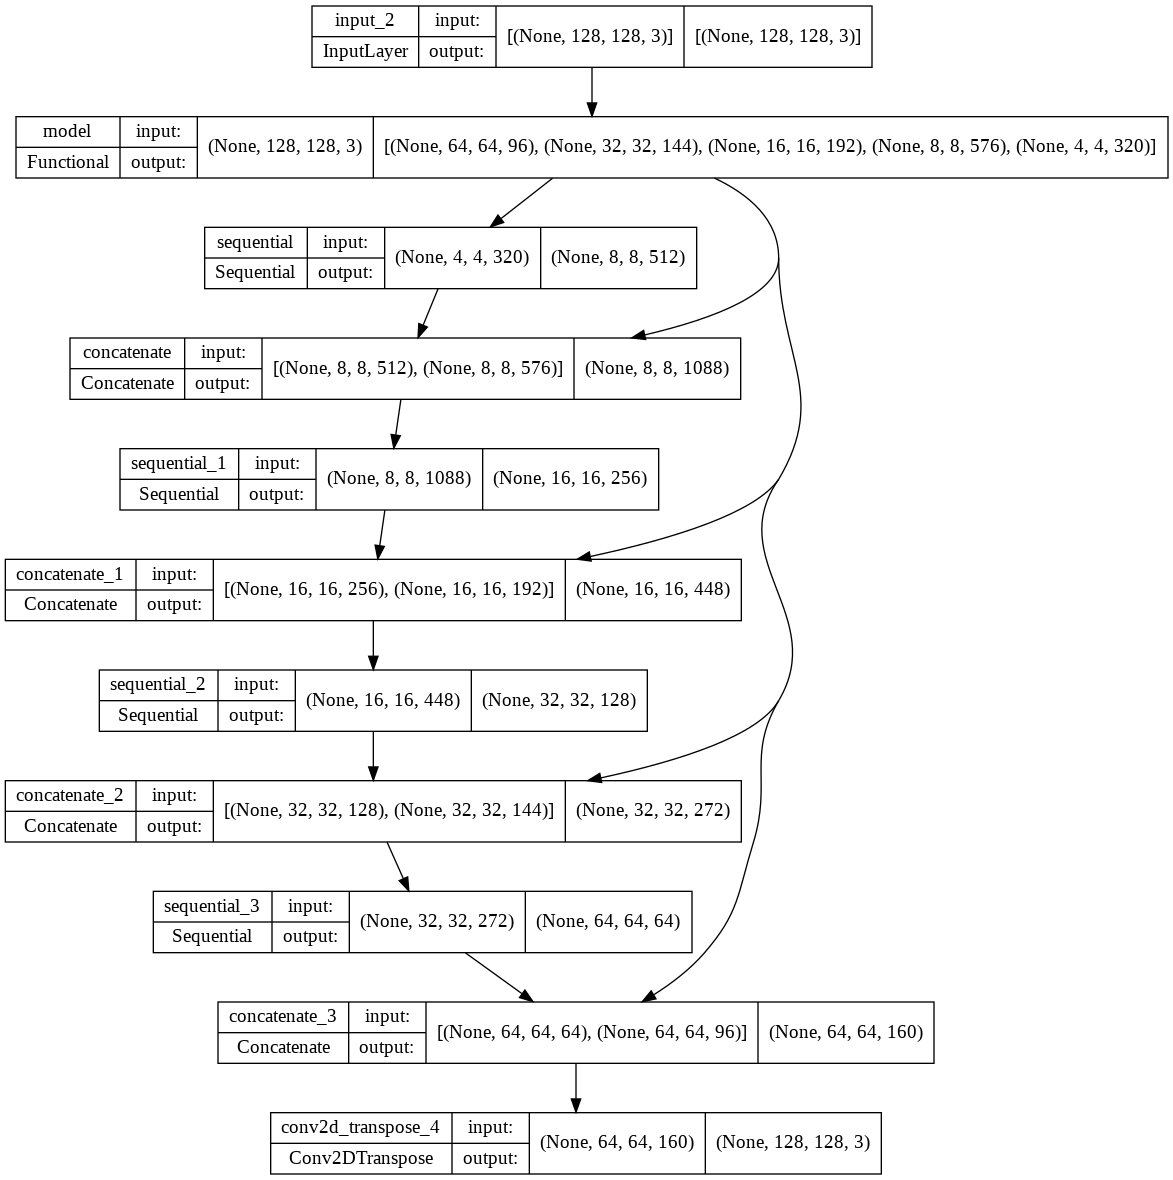

In [17]:
tf.keras.utils.plot_model(model, show_shapes=True)

In [18]:
def create_mask(pred_mask):
    pred_mask = tf.argmax(pred_mask, axis=-1)
    pred_mask = pred_mask[..., tf.newaxis]
    return pred_mask[0]

In [19]:
import numpy as np

z = np.random.uniform(low=0, high=2, size=(1, 128, 128, 3))
print(z.shape)
z = tf.argmax(z, axis=-1)
print(z.shape)
z = z[..., tf.newaxis]
print(z.shape)
# print(z[0])
print(z[0].shape)

(1, 128, 128, 3)
(1, 128, 128)
(1, 128, 128, 1)
(128, 128, 1)


In [20]:
print(model.predict(tf.expand_dims(sample_image, 0)).shape)
print(create_mask(model.predict(tf.expand_dims(sample_image, 0))).shape)

(1, 128, 128, 3)
(128, 128, 1)


In [21]:
def show_predictions(dataset=None, num=1):
    if dataset:
        for image, mask in dataset.take(num):
            pred_mask = model.predict(image)
            display([image[0], mask[0], create_mask(pred_mask)])
    else:
        display([sample_image, sample_mask, create_mask(model.predict(sample_image[tf.newaxis, ...]))])

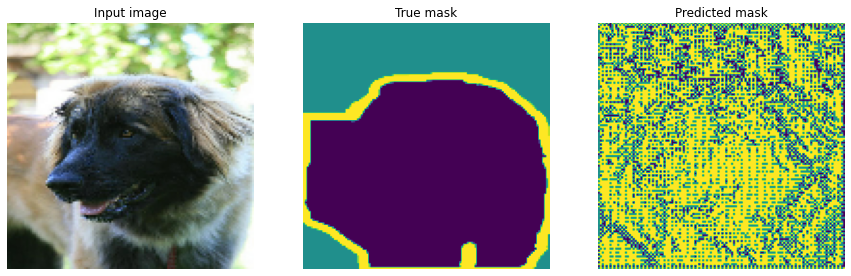

In [22]:
show_predictions()

In [23]:
class DisplayCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, log=None):
        clear_output(wait=True)
        show_predictions()
        print("\nSample prediction after epoch {} \n".format(epoch + 1))


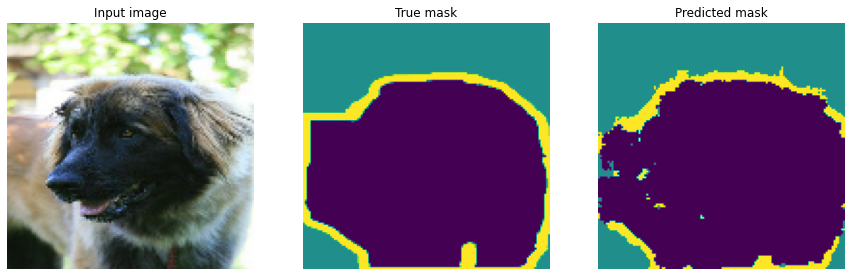


Sample prediction after epoch 20 

57/57 [==============================] - 18s 311ms/step - loss: 0.1849 - accuracy: 0.9181 - val_loss: 0.2953 - val_accuracy: 0.8907


In [24]:
EPOCHS = 20
VAL_SUBSPLITS = 5
VALIDATION_STEPS = info.splits['test'].num_examples // BATCH_SIZE // VAL_SUBSPLITS

model_history = model.fit(
    train_batches, epochs=EPOCHS, steps_per_epoch=STEPS_PER_EPOCH, 
    validation_steps=VALIDATION_STEPS, validation_data=test_batches, 
    callbacks=[DisplayCallback()]
)

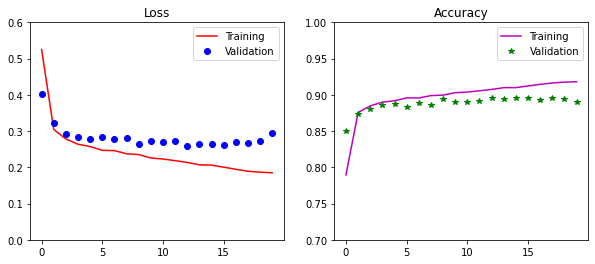

In [25]:
# Visualization
loss = model_history.history['loss']
val_loss = model_history.history['val_loss']

acc= model_history.history['accuracy']
val_acc = model_history.history['val_accuracy']

epoch_range = model_history.epoch

plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(epoch_range, loss, 'r', label='Training')
plt.plot(epoch_range, val_loss, 'bo', label='Validation')
plt.title("Loss")
plt.ylim([0, 0.6])
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epoch_range, acc, 'm', label='Training')
plt.plot(epoch_range, val_acc, 'g*', label="Validation")
plt.ylim([0.7, 1])
plt.title("Accuracy")
plt.legend()

plt.show()

##Make Predictions

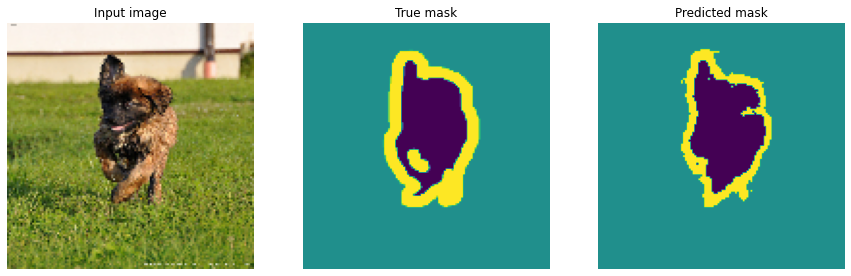

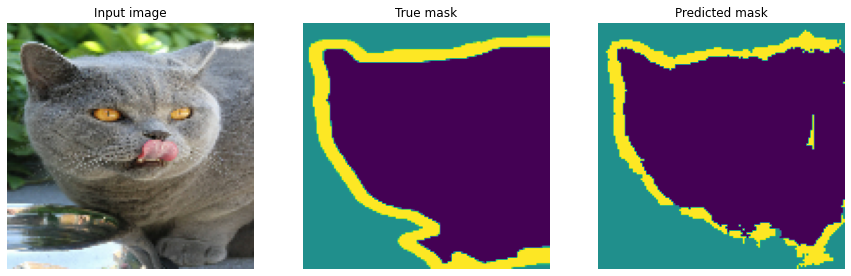

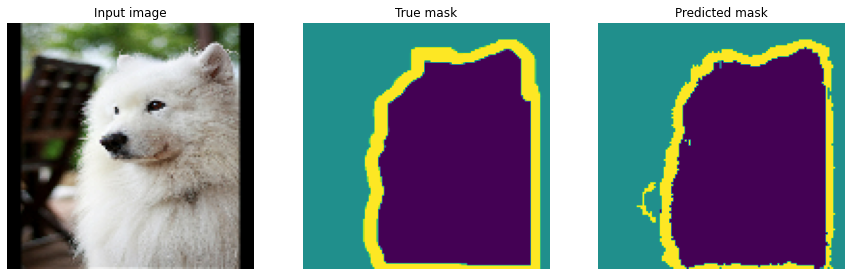

In [26]:
show_predictions(test_batches, 3)

In [27]:
try:
    model_history = model.fit(train_batches, epochs=EPOCHS, 
                              steps_per_epoch=STEPS_PER_EPOCH, 
                              class_weight={0:2.0, 1:2.0, 2:1.0})
    assert False
except Exception as e:
    print(f"Expected: {type(e).__name__}: {e}")

Expected: ValueError: `class_weight` not supported for 3+ dimensional targets.


###class weights

In [53]:
label = [0, 0, 1]
predictions = [[-3., 0], [-3 ,0], [-3, 0]]
sample_weight = [1, 10]
sample_weights = tf.gather(sample_weight, indices=tf.cast(label, tf.int32))
print(sample_weights)

loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True,
                                                     reduction=tf.losses.Reduction.NONE)
print(loss(label, predictions).numpy())
print()
print(loss(label, predictions, sample_weights).numpy())


tf.Tensor([ 1  1 10], shape=(3,), dtype=int32)
[3.0485873  3.0485873  0.04858733]

[3.0485873  3.0485873  0.48587328]


In [54]:
def add_sample_weight(image, label):
    class_weight = tf.constant([2.0, 2.0, 1.0])
    class_weight = class_weight / tf.reduce_sum(class_weight)

    sample_weight = tf.gather(class_weight, indices=tf.cast(label, tf.int32))
    return image, label, sample_weight
    

In [55]:
train_batches.map(add_sample_weight).element_spec

(TensorSpec(shape=(None, 128, 128, 3), dtype=tf.float32, name=None),
 TensorSpec(shape=(None, 128, 128, 1), dtype=tf.float32, name=None),
 TensorSpec(shape=(None, 128, 128, 1), dtype=tf.float32, name=None))

In [61]:
weighted_model = unet_model(OUTPUT_CLASSES)
weighted_model.compile(
    optimizer='adam', 
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), 
    metrics=['accuracy']    
)


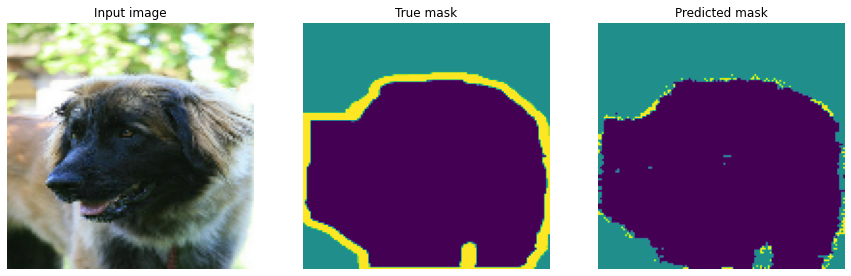


Sample prediction after epoch 20 

57/57 [==============================] - 18s 317ms/step - loss: 0.0281 - accuracy: 0.9505 - val_loss: 0.3816 - val_accuracy: 0.8885


In [62]:
weighted_model_history = weighted_model.fit(
    train_batches.map(add_sample_weight),
    epochs=EPOCHS,
    steps_per_epoch=STEPS_PER_EPOCH,
    validation_steps=VALIDATION_STEPS,
    validation_data=test_batches,
    callbacks=[DisplayCallback()]
)

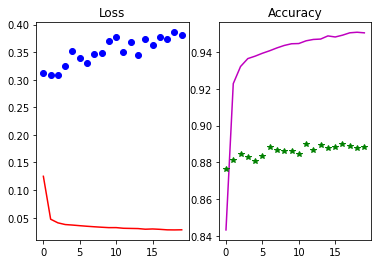

In [65]:
loss = weighted_model_history.history['loss']
val_loss = weighted_model_history.history['val_loss']

acc = weighted_model_history.history['accuracy']
val_acc = weighted_model_history.history['val_accuracy']
epoch_range = weighted_model_history.epoch

plt.figure()
plt.subplot(1, 2, 1)
plt.plot(epoch_range, loss, 'r', label='Training')
plt.plot(epoch_range, val_loss, 'bo', label='Validation')
plt.title('Loss')

plt.subplot(1, 2, 2)
plt.plot(epoch_range, acc, 'm', label='Training')
plt.plot(epoch_range, val_acc, 'g*', label='Validation')
plt.title("Accuracy")

plt.show()

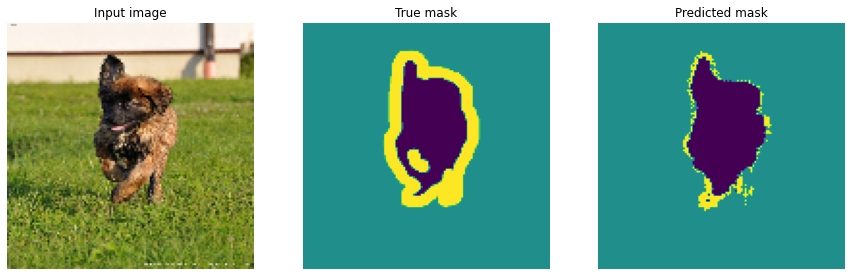

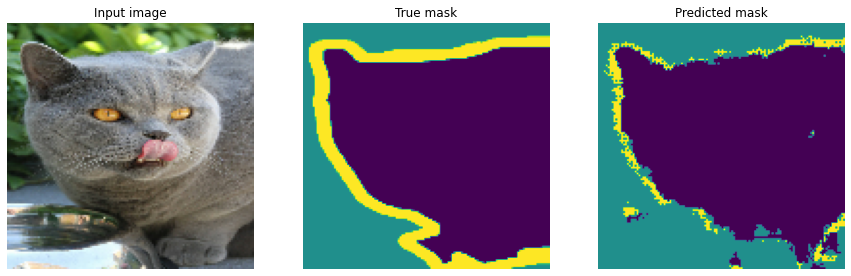

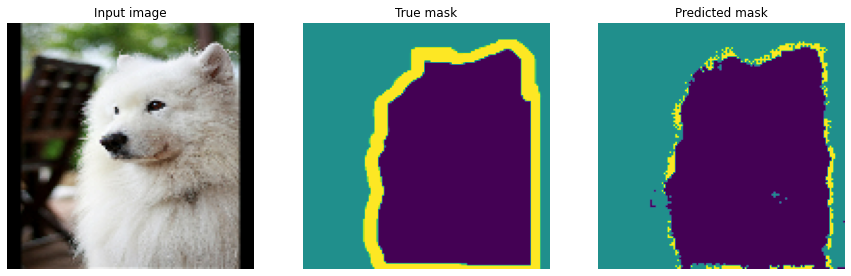

In [66]:
show_predictions(test_batches, 3)